In [1]:
!pip install torch torchvision opencv-python matplotlib tqdm
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
from transformers import pipeline
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm


2025-07-02 17:58:17.880351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751479098.297511      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751479098.418455      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
video_path = "/kaggle/input/pencil-depth/Pencil_Depth_Mapping.mov"  # Change to your video path
cap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
cap.release()


In [4]:
depth_pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [5]:
depth_maps = []
for frame in tqdm(frames, desc="Depth Mapping"):
    pil_img = Image.fromarray(frame)
    depth = depth_pipe(pil_img)["depth"]
    # Convert to numpy array and normalize for visualization
    depth_np = np.array(depth)
    depth_norm = cv2.normalize(depth_np, None, 0, 255, cv2.NORM_MINMAX)
    depth_maps.append(depth_norm.astype(np.uint8))


Depth Mapping: 100%|██████████| 291/291 [00:47<00:00,  6.12it/s]


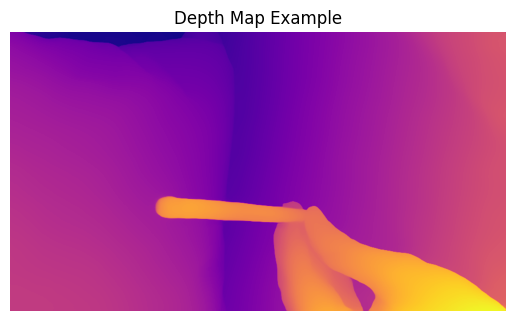

In [6]:
import matplotlib.pyplot as plt

plt.imshow(depth_maps[150], cmap='plasma')
plt.title("Depth Map Example")
plt.axis('off')
plt.show()


In [7]:
height, width = depth_maps[0].shape
out = cv2.VideoWriter('/kaggle/working/depth_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height), False)

for depth_map in depth_maps:
    out.write(depth_map)
out.release()
